In [2]:
%reload_ext autoreload
%autoreload 2
import sys; sys.path.append('..')
from generate_data import stack_with_img, load_pretrained
from src.data_utils import imagenet_classes
from jupyter_preproc import smoothen, probs_to_softacc
import numpy as np
import time
import matplotlib.pyplot as plt
rng = np.random.default_rng(5)
import seaborn as sns
import matplotlib as mpl
from os import listdir 
from os.path import abspath, isfile, join
from glob import glob
import torch
from natsort import natsorted

def get_models():
    checkpoint_names = natsorted(listdir(glob('/home/jupyter/dist-shift/gal/resnet50/*')[0]))
    models = {}
    for i, ckpt_dir in enumerate(glob('/home/jupyter/dist-shift/gal/resnet50/*')):
        print(f'loading model dir {i+1} out of 10 (into RAM)')
        all_paths = [join(ckpt_dir,checkpoint_name) for checkpoint_name in checkpoint_names]
        models[i] = []
        for path in all_paths:
            model = load_pretrained(path)
            models[i].append(model)
    return models
        
MODELS = get_models()

loading model dir 1 out of 10
loading model dir 2 out of 10
loading model dir 3 out of 10
loading model dir 4 out of 10
loading model dir 5 out of 10
loading model dir 6 out of 10
loading model dir 7 out of 10
loading model dir 8 out of 10
loading model dir 9 out of 10
loading model dir 10 out of 10


In [11]:
from generate_data import get_image, get_average_logs
import pandas as pd
main_dir = '/home/jupyter/dist-shift/new_images/'

def get_image_data(im, models=MODELS):
    checkpoint_names = natsorted(listdir(glob('/home/jupyter/dist-shift/gal/resnet50/*')[0]))
    logits_dict = {}
    for i, ckpt_dir in enumerate(glob('/home/jupyter/dist-shift/gal/resnet50/*')):
        print(f'inference on model dir {i+1} out of 10')
        all_logits = []
        for model in models[i]:
            with torch.no_grad():
                raw_pred = model(im)
            all_logits += [raw_pred.numpy()]
        logits_dict[f'model_{i}_results'] = all_logits
    return logits_dict

def get_data(img_name, label=None):
    assert img_name.lower().endswith('jpg') or img_name.lower().endswith('jpeg') or img_name.lower().endswith('png'), "we only support jpegs and pngs"
    assert len(img_name.split('.')) == 2, 'we do not support things with two dots in image name please change name'
    
    image_path = join(main_dir, 'jpegs', img_name)
    base_name = img_name.split('.')[0]
    logits_path = join(main_dir, 'results', f'{base_name}.npz')
    
    if isfile(logits_path):
        return get_image(image_path, as_pillow=True), np.load(logits_path, 'r')
    else:
        print('this should take ~10 seconds')
        im = get_image(image_path)
        all_logits = get_image_data(im)
        logs = get_average_logs(all_logits, label=label)
        
        
        # todo: right now only supports resnet50
        xs = pd.read_csv('/home/jupyter/dist-shift/gal/x.csv')
        print(xs.shape)
        logs['x'] = xs.values[:, 1]
        
        print(f'data is saved to: {logits_path}')
        with open(logits_path, 'wb') as f:
            np.savez(f, **logs)
        return get_image(image_path, as_pillow=True), logs

    
gname = 'imagenet_val'
classes = imagenet_classes
t = 'probs'
smooth = True
num_gridpts = 50 # num pts on x-axis
sigma = 2.0
xkey = 'x'
sns.reset_defaults()
mpl.rcParams['font.family'] = 'sans-serif'

this should take a 1-2 minutes
inference on model dir 1 out of 10
inference on model dir 2 out of 10
inference on model dir 3 out of 10
inference on model dir 4 out of 10
inference on model dir 5 out of 10
inference on model dir 6 out of 10
inference on model dir 7 out of 10
inference on model dir 8 out of 10
inference on model dir 9 out of 10
inference on model dir 10 out of 10
(20, 2)
data is saved to: /home/jupyter/dist-shift/new_images/results/composite0.npz


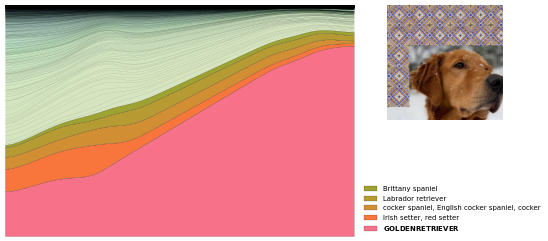

In [25]:
img, data = get_data('composite0.jpeg')

res = smoothen(data, xkey, t)

xx = res[f'{xkey}_grid']
yy = res[f'{t}_smooth']

stack_with_img(img, xx, yy, classes)
plt.show()